In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ReadOut import read_bin_file

from datetime import timedelta, datetime
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from scipy import signal

timestamps = pd.read_csv('Overnight_2705_2355/FA_06_91_01_30_00.csv')
#print(timestamps.columns)
data = pd.read_csv('Overnight_2705_2355/VNYMR.csv')
#print(data.columns)

print((np.diff(timestamps['TimeSyncIn'])/1e9) **(-1))
print((np.mean(np.diff(timestamps['TimeSyncIn'])/1e9) **(-1)))
print("Actual length:",len(timestamps), "Expected Length: 964320")
print("Delta_t:", (timestamps['TimeSyncIn'].iloc[-1] - timestamps['TimeSyncIn'].iloc[0])/1e9)
print("Delta_t [HH:MM:SS]", pd.to_timedelta((timestamps['TimeSyncIn'].iloc[-1] - timestamps['TimeSyncIn'].iloc[0])/1e9, unit='s'))
# I assume the total time (resulting in the expected length) is not correct (too short) resulting in more data points than expected.

[40.00160006 40.         40.         ... 39.99840006 40.
 40.        ]
40.000000000000064
Actual length: 964370 Expected Length: 964320
Delta_t: 24109.225
Delta_t [HH:MM:SS] 0 days 06:41:49.225000


In [5]:
def ms2_to_mg(ms2):
    return ms2 / 9.80665 * 1000 

def mg_to_ms2(mg):
    return mg * 9.80665 / 1000  

def seconds_to_hms(x, pos):
    hours = int(x // 3600)
    minutes = int((x % 3600) // 60)
    seconds = int(x % 60)
    return f'{hours:02}:{minutes:02}:{seconds:02}'

def ms2_to_mGal(ms2):
    return ms2 / 9.80665 * 1e6

def mGal_to_ms2(mg):
    return mg * 9.80665 / 1e6 


def filt_lp(y_full, freq_lowpass, fs=40.):
    Wn = freq_lowpass
    sos = signal.butter(N=8, Wn=Wn,
                        btype='lowpass',
                        output='sos',
                        fs=fs)
    return signal.sosfiltfilt(sos, y_full)


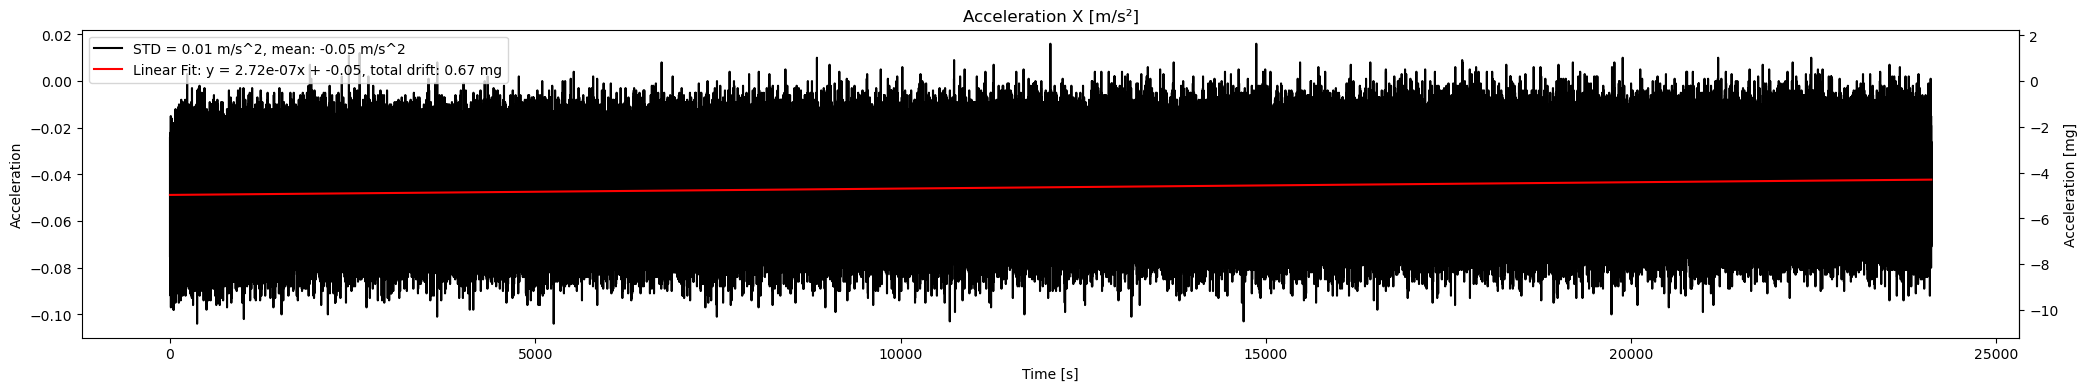

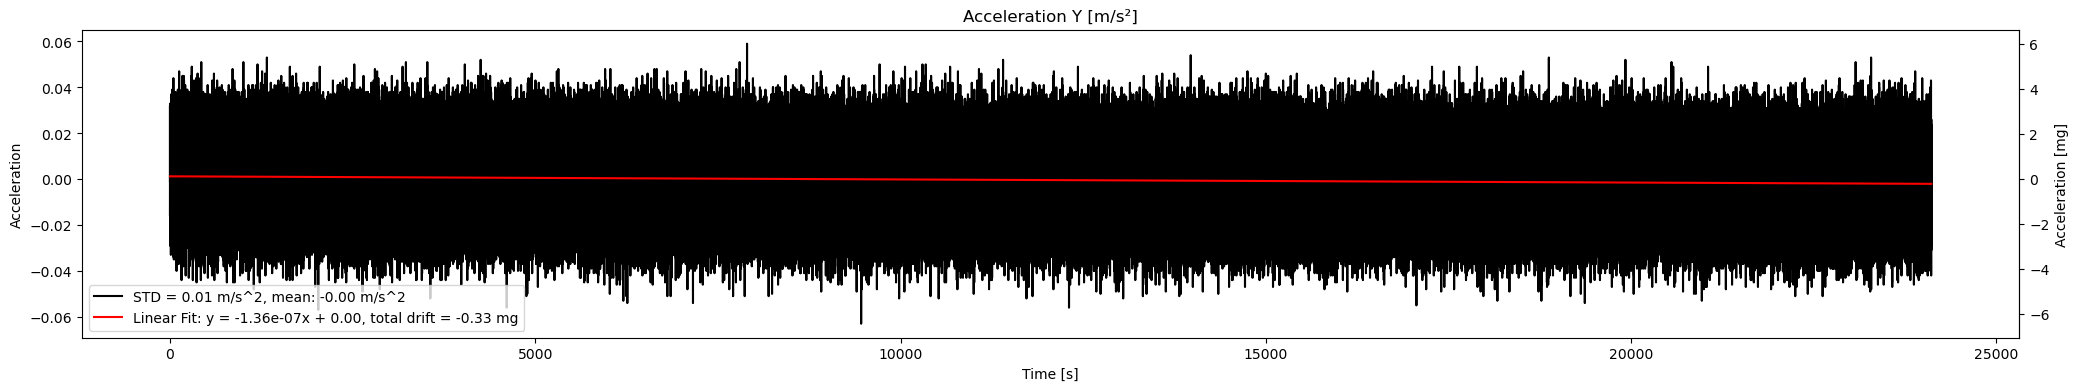

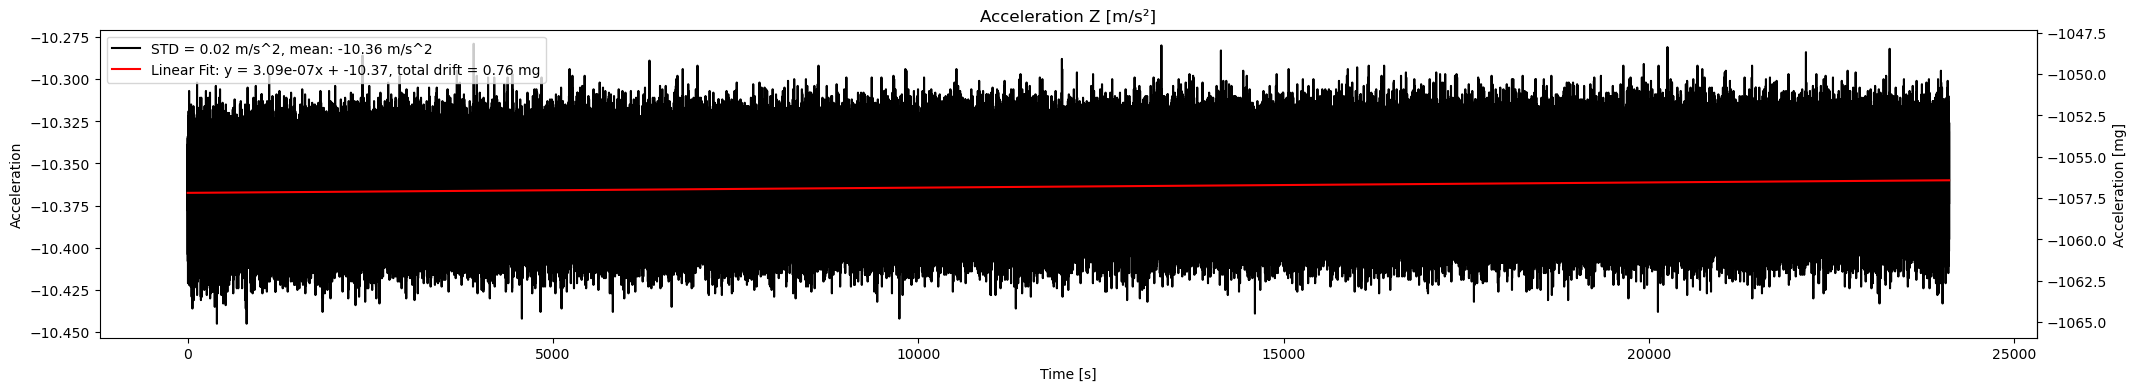

In [6]:

# PLOT TO SECOND TO LAST BECAUSE LENGTH OF ARRAY NOT THE SAME FOR WHATEVER REASON

rel_time = timestamps['TimeSyncIn'] - timestamps['TimeSyncIn'].iloc[0]
time_s = rel_time / 1e9  # Convert to seconds

fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(time_s, data['AccelX'][:-1], "k", label=f'STD = {data["AccelX"].std():.2f} m/s^2, mean: {data["AccelX"].mean():.2f} m/s^2', markersize=1)
a0, a1 = np.polyfit(time_s, data['AccelX'][:-1], 1)
linx =  a0*time_s + a1
ax.plot(time_s,linx, 'r', label=f'Linear Fit: y = {a0:.2e}x + {a1:.2f}, total drift: {ms2_to_mg(linx.iloc[-1]  - linx.iloc[0]):.2f} mg')

ax.set_title("Acceleration X [m/s²]")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Acceleration")
secax = ax.secondary_yaxis('right', functions=(ms2_to_mg, mg_to_ms2))
secax.set_ylabel('Acceleration [mg]')
ax.legend()

# Accel Y
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(time_s, data['AccelY'][:-1], "k", label=f'STD = {data["AccelY"].std():.2f} m/s^2, mean: {data["AccelY"].mean():.2f} m/s^2', markersize=1)

a0, a1 = np.polyfit(time_s, data['AccelY'][:-1], 1)
liny = a0*time_s + a1
ax.plot(time_s,liny, 'r', label=f'Linear Fit: y = {a0:.2e}x + {a1:.2f}, total drift = {ms2_to_mg(liny.iloc[-1] - liny.iloc[0]):.2f} mg')

ax.set_title("Acceleration Y [m/s²]")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Acceleration")
secax = ax.secondary_yaxis('right', functions=(ms2_to_mg, mg_to_ms2))
secax.set_ylabel('Acceleration [mg]')
ax.legend()

# Accel Z
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(time_s, data['AccelZ'][:-1], "k", label=f'STD = {data["AccelZ"].std():.2f} m/s^2, mean: {data["AccelZ"].mean():.2f} m/s^2', markersize=1)

a0, a1 = np.polyfit(time_s, data['AccelZ'][:-1], 1)
linz =  a0*time_s + a1
ax.plot(time_s, linz, 'r', label=f'Linear Fit: y = {a0:.2e}x + {a1:.2f}, total drift = {ms2_to_mg(linz.iloc[-1] - linz.iloc[0]):.2f} mg')


ax.set_title("Acceleration Z [m/s²]")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Acceleration")
secax = ax.secondary_yaxis('right', functions=(ms2_to_mg, mg_to_ms2))
secax.set_ylabel('Acceleration [mg]')
ax.legend()

plt.show()



C:\Users\yslug\AppData\Local\Temp\ipykernel_29224\1152739304.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


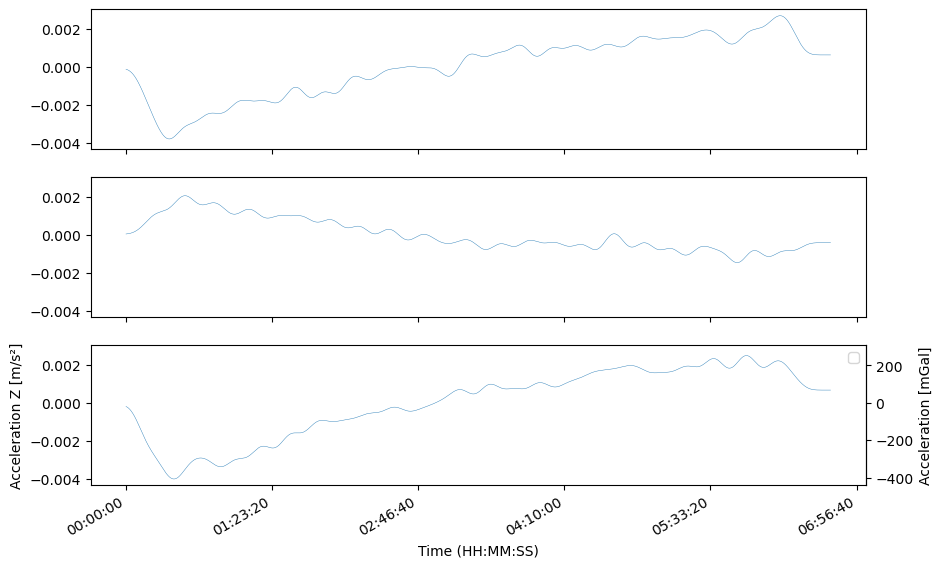

In [9]:

hms_formatter = FuncFormatter(seconds_to_hms)
kind = 'Accel'
# LP filter period
period_lim = 900.
fs = 40

# Create joint plot
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 7), sharex='all', sharey='all')
for ax, comp in zip(axs, ['X', 'Y', 'Z']):
    chan = f'{kind}{comp}'
    
    values = data[chan][:-1] 
    N = len(values)
    len_sec = N / fs
    # Remove mean    
    data_demean = values - values.mean()

    # Taper data before filter application
    taper = period_lim / len_sec * 4
    data_taper = signal.windows.tukey(M=len(data_demean), alpha=taper) * data_demean

    # LP filter data
    data_filt = filt_lp(data_taper, 
                        freq_lowpass=1./period_lim,
                        fs=fs)

    # The idea was to get a proper time axis, but NumPy Datetime does not work like this :-(
    time = time_s
    ax.plot(time, data_filt - data_filt.mean(), lw=0.3)
            #label=f'STD = {data_filt.std():.2f} m/s^2, mean: {data_filt.mean():.2f} m/s^2', markersize=1)
    a0, a1 = np.polyfit(time, data_filt- data_filt.mean(), 1)
    linx =  a0*time + a1
    #ax.plot(time, linx, 'r', label=f'Linear Fit: y = {a0:.2e}x + {a1:.2f}, total drift: {ms2_to_mg(linx[-1] - linx[0]):.2f} mg')

ax.xaxis.set_major_formatter(hms_formatter)
fig.autofmt_xdate()
ax.set_xlabel("Time (HH:MM:SS)")
ax.set_ylabel(f"Acceleration {comp} [m/s²]")
#ax.set_ylim(-0.001, 0.001)
secax = ax.secondary_yaxis('right', functions=(ms2_to_mGal, mGal_to_ms2))
secax.set_ylabel('Acceleration [mGal]')

ax.legend()
plt.show()

Text(0.5, 1.0, 'Pressure, Overnight_2705')

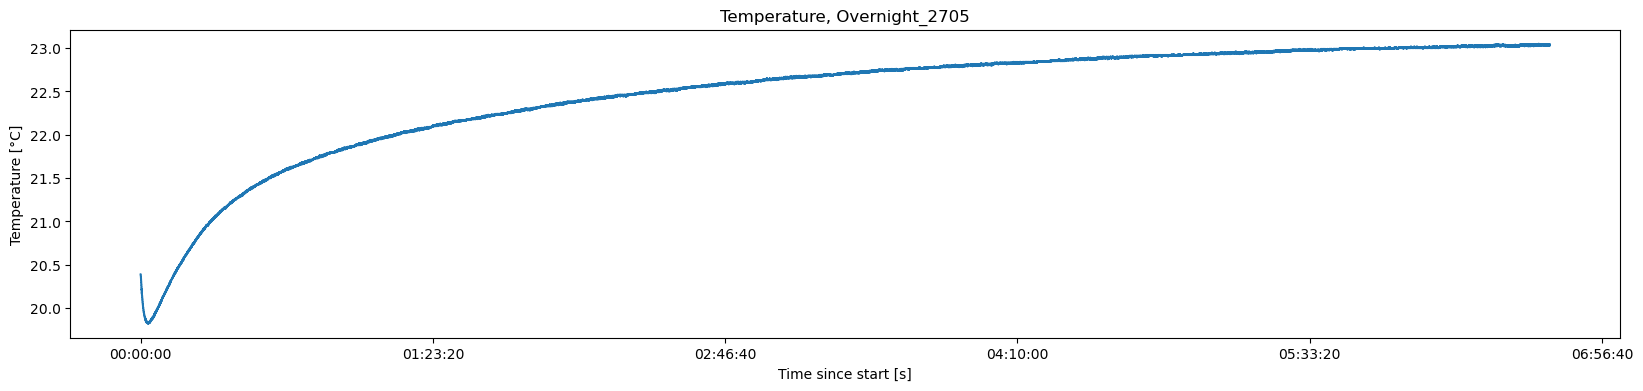

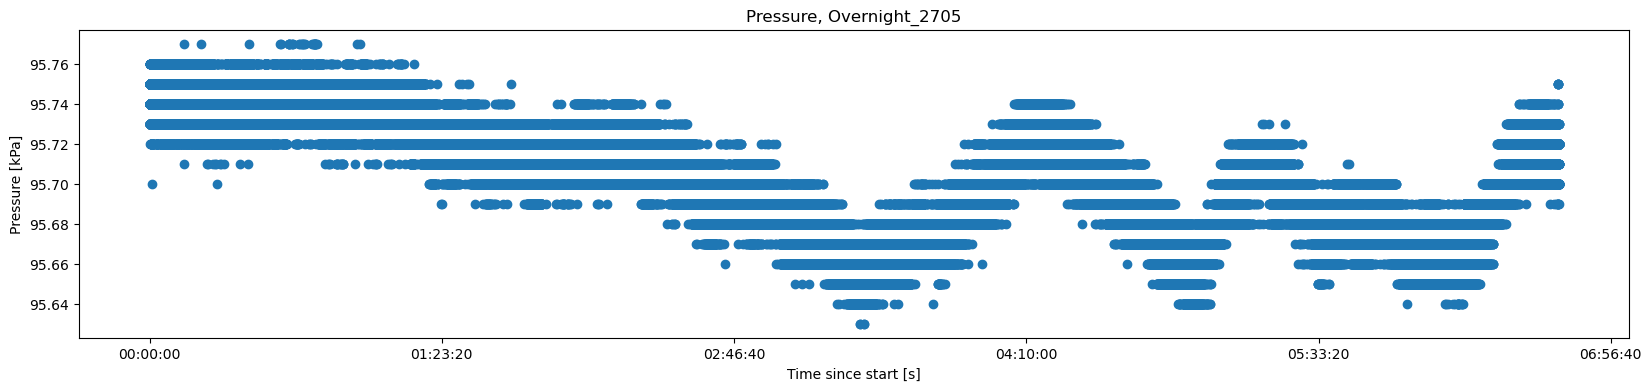

In [18]:
plt.figure(figsize = (20,4))
plt.plot(time_s, timestamps['Temperature'])
# I know this is a very stupid way to do it like this, i just wanted to quickly check how the temperature trend compares to the acceleration so i scaled the acceleration randomly:
# plt.plot(time, (data_filt - data_filt.mean())*900 + 21, lw=0.3, label = "z Accel")
plt.gca().xaxis.set_major_formatter(hms_formatter) 
plt.ylabel("Temperature [°C]")
plt.xlabel("Time since start [s]")
plt.title("Temperature, Overnight_2705")

plt.figure(figsize = (20,4))
plt.plot(time_s, timestamps['Pressure'], "o")
plt.gca().xaxis.set_major_formatter(hms_formatter) 
plt.ylabel("Pressure [kPa]")
plt.xlabel("Time since start [s]")
plt.title("Pressure, Overnight_2705")

